In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import sklearn.metrics
import seaborn as sns
from datetime import datetime
from itertools import product
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [2]:
##EDA: part 1, daily transaction
sales_train = pd.read_csv('sales_train.csv')
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


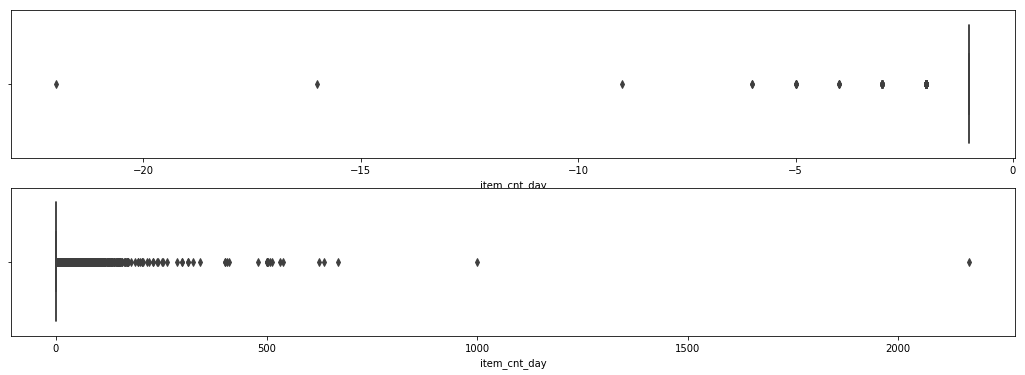

In [22]:
fig, ax = plt.subplots(2,1,figsize=(18,6))
sns.boxplot(sales_train.loc[sales_train.item_cnt_day<0, 'item_cnt_day'], ax=ax[0])
sns.boxplot(sales_train.loc[sales_train.item_cnt_day>0, 'item_cnt_day'], ax=ax[1])

#<0 due to item return and no return with huge number; >1000 considered as outlier and to be dropped.

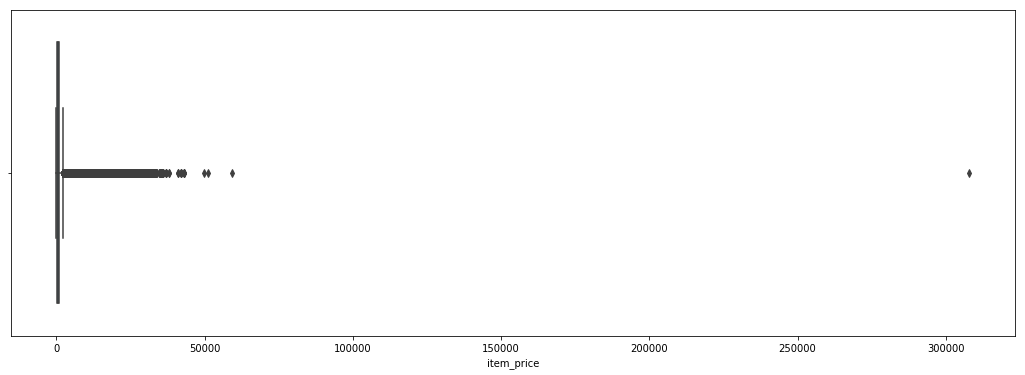

In [20]:
plt.figure(figsize=(18,6))
sns.boxplot(x=sales_train.item_price)

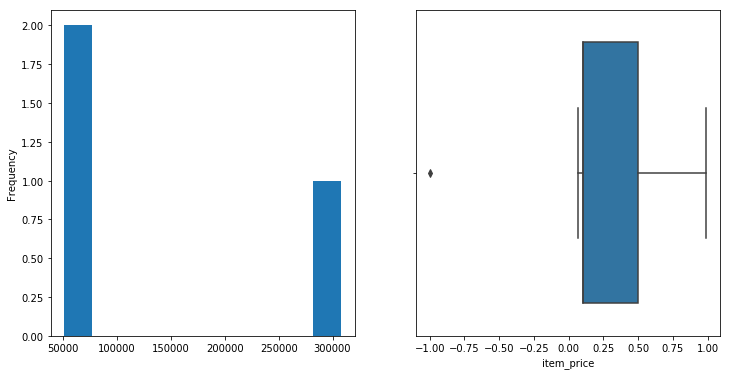

In [21]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
sales_train.loc[sales_train.item_price>50000,'item_price'].plot.hist(ax=ax[0])
sns.boxplot(sales_train.loc[sales_train.item_price<1, 'item_price'], ax=ax[1])
#>50000 3 data points, considered as outliers and to be removed; 1 data point less than zero, considered as data collection issue, to be imputered with item mean.

Text(0.5,1,u'By shop_id')

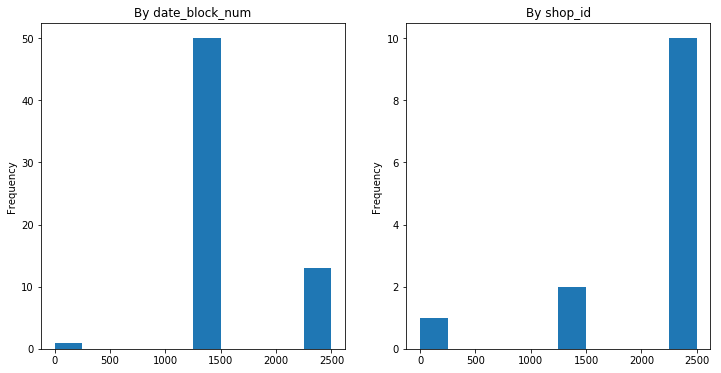

In [24]:
#imputer the item_price < 0
fig, ax = plt.subplots(1,2,figsize=(12,6))
sales_train.loc[(sales_train.item_id==2973)&(sales_train.date_block_num==4), 'item_price'].plot.hist(ax=ax[0])
ax[0].set_title('By date_block_num')
sales_train.loc[(sales_train.shop_id==32)&(sales_train.item_id==2973), 'item_price'].plot.hist(ax=ax[1])
ax[1].set_title('By shop_id')
#There are two distributions for this item in either date_block_num (05/2013) or shop (id 32). However, in date_block-num plot,
#value 1249 dominates while value 2499 dominates in shop plot.
#Plot date vs item_price for this item may shallow some light on its likely value at the date the item sold.

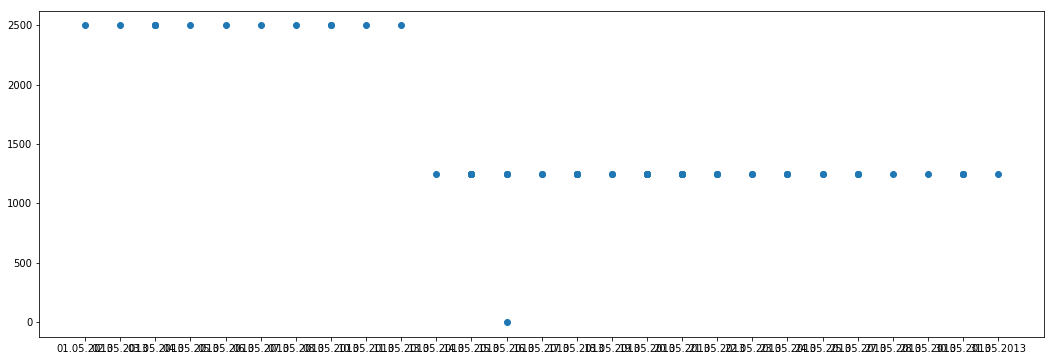

In [25]:
plt.figure(figsize=(18,6))
plt.plot_date(x=sales_train.loc[(sales_train.item_id==2973)&(sales_train.date_block_num==4), 'date'], y=sales_train.loc[(sales_train.item_id==2973)&(sales_train.date_block_num==4), 'item_price'])
#The item_price vs date plot at date_block_num 4 clearly suggests that the item was more likely sold at price value 1249.
#Thus, we will replace it with the true item_price 1249.

In [27]:
item = pd.read_feather('it_en.feather')
item = item.rename(columns={'it_name': 'item_name_ru', 'it_id': 'item_id', 'itc_id': 'item_category_id', 'en_it_name': 'item_name'})
item.head()

,item_name_ru,item_id,item_category_id,item_name
0,ВО ВЛАСТИ НАВАЖДЕНИЯ ПЛАСТ D,0.0,40.0,IN THE FIRE OF DREATING THE PLAST D
1,ABBYY FineReader 12 Professional Edition Full ...,1.0,76.0,ABBYY FineReader 12 Professional Edition Full ...
2,В ЛУЧАХ СЛАВЫ UNV D,2.0,40.0,In the glories of the glory UNV D
3,ГОЛУБАЯ ВОЛНА Univ D,3.0,40.0,BLUE WAVE Univ D
4,КОРОБКА СТЕКЛО D,4.0,40.0,BOX GLASS D


In [30]:
##EDA: part 2, shops info
shops = pd.read_feather('sh_en.feather')
shops = shops.rename(columns={'sname': 'shop_name_ru', 'sid': 'shop_id', 'en_sname': 'shop_name'})
sorted(shops.shop_name)

#By sorting shop names, it seems there are 4 duplicates. The shop ids will be condensed into 56.
#  u'RostovNaDonu TRK Megacenter Horizon', u'RostovNaDonu TRK Megacenter Horizon Ostrovnoy'
#  u'Yakutsk Ordzhonikidze 56', u'Yakutsk Ordzhonikidze 56 fr'
#  u'Zhukovsky st Chkalov 39m', u'Zhukovsky str. Chkalov 39 m\xb2'
#  Якутск ТЦ Центральный фран, Якутск ТЦ Центральный

[u'Adygea Shopping Center Mega',
 u'Balashikha TRK October Kinomir',
 u'Chekhov SEC Carnival',
 u'Digital warehouse 1C Online',
 u'Kaluga SEC XXI century',
 u'Kazan TC Behetlet',
 u'Kazan TC ParkHouse II',
 u'Khimki Shopping Center Mega',
 u'Kolomna Shopping Center Rio',
 u'Krasnoyarsk Shopping Center June',
 u'Krasnoyarsk Shopping Center Vzletka Plaza',
 u'Kursk Shopping Center Pushkinsky',
 u'Moscow MTRC Afi Mall',
 u'Moscow Perlovsky shopping center',
 u'Moscow Sale',
 u'Moscow Shop \u042121',
 u'Moscow Shopping Center MEGA Belaya Dacha II',
 u'Moscow Shopping Center Silver House',
 u'Moscow TC Areal Belyaevo',
 u'Moscow TC Budenovskiy Pavil K7',
 u'Moscow TC Budyonovsky PAV A2',
 u'Moscow TC MEGA Teply Stan II',
 u'Moscow TC Semenovskiy',
 u'Moscow TC The New Century of Novokosino',
 u'Moscow TRK Atrium',
 u'Mytisci TRK XL 3',
 u'Novosibirsk Shopping Center Mega',
 u'Novosibirsk TRC Gallery Novosibirsk',
 u'Omsk Shopping Center Mega',
 u'Online shop Emergency',
 u'Outbound Trade',


In [31]:
#EDA: part 3, item category info
categories = pd.read_feather('itc_en.feather')
categories.head(2)

,itc_name,itc_id,en_itc_name
0,PC Гарнитуры Наушники,0,PC Headsets Headphones
1,Аксессуары PS2,1,PS2 Accessories


In [32]:
def categoryLoadPreprocess():    
    '''Load categories file, extract and preprocess features.'''
    
    categories = pd.read_feather('itc_en.feather')
    categories = categories.rename(columns={'itc_name': 'item_category_name_ru', 'itc_id': 'item_category_id','en_itc_name': 'item_category'})
    
    categories_features = ['music', 'game', 'book', 'gifts', 'movie', 'payment cards', 'programs', 'ps', 'xbox', 'accessories', 'consoles', 'software', 'office', 'tickets']
    categories['item_category'] =categories['item_category'].str.lower()
      
    for f in categories_features:
        categories[f] = categories['item_category'].str.contains(f)
        categories[f] = categories[f].astype(int)
        
    categories['games'] = categories['game'] + categories['ps'] + categories['xbox'] #classify 'ps' and 'xbox' as games category
    categories['accessories'] = categories['accessories'] + categories['consoles'] #classifty 'consoles' as accessories
    categories['programs'] = categories['programs'] + categories['software'] + categories['office'] #classify 'software' and 'office' as program
    categories.loc[categories.games>1, 'games'] = 1
    categories.loc[categories.accessories>1, 'accessories'] = 1
    categories.loc[categories.programs>1, 'programs'] = 1
     
    redudant_features = ['movie', 'music', 'games'] # category_id 32 should be classified as payment cards category only
    
    for feature in redudant_features:
        categories.loc[categories.item_category_id==32, feature] = 0 
        
    categories.loc[categories.item_category_id==35, 'games'] = 0 #payment cards only.
    
    category_ids = [0, 8, 81, 82, 83] #These can be classified as "others"
    
    categories['others'] = 0
    
    for id in category_ids:
        categories.loc[categories.item_category_id==id, 'others'] = 1
        
    categories = categories.drop(['game', 'ps', 'xbox', 'consoles', 'software', 'office'], axis=1)
    
    return categories

categories = categoryLoadPreprocess()
categories.head()

,item_category_name_ru,item_category_id,item_category,music,book,gifts,movie,payment cards,programs,accessories,tickets,games,others
0,PC Гарнитуры Наушники,0,pc headsets headphones,0,0,0,0,0,0,0,0,0,1
1,Аксессуары PS2,1,ps2 accessories,0,0,0,0,0,0,1,0,1,0
2,Аксессуары PS3,2,ps3 accessories,0,0,0,0,0,0,1,0,1,0
3,Аксессуары PS4,3,ps4 accessories,0,0,0,0,0,0,1,0,1,0
4,Аксессуары PSP,4,psp accessories,0,0,0,0,0,0,1,0,1,0


In [54]:
#EDA: part 4, monthly aggregated data
# data_all_m = pd.read_csv('data_all_m2.csv')
# data_all_m = data_all_m.drop('Unnamed: 0', axis=1)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
data_all_m.sample(10)

,shop_id,item_id,date_block_num,item_price_M_avg,item_cnt_M_avg,shop_id_item_price_M_avg,shop_id_item_cnt_M_75,shop_id_item_cnt_M_avg,shop_id_item_cnt_M_25,shop_id_item_cnt_M_sum,shop_id_item_cnt_M_10,shop_id_item_cnt_M_90,item_id_item_price_M_avg,item_id_item_cnt_M_10,item_id_item_cnt_M_75,item_id_item_cnt_M_90,item_id_item_cnt_M_sum,item_id_item_cnt_M_25,item_id_item_cnt_M_avg,category_item_price_M_avg,category_item_cnt_M_10,category_item_cnt_M_25,category_item_cnt_M_sum,category_item_cnt_M_75,category_item_cnt_M_avg,category_item_cnt_M_90,shop_item_revenue_M_delta,shop_revenue_M_delta,item_revenue_M_delta,category_revenue_M_delta,item_price_M_avg_lag1,item_price_M_avg_lag2,item_price_M_avg_lag3,item_price_M_avg_lag4,item_price_M_avg_lag5,item_price_M_avg_lag6,item_price_M_avg_lag12,item_cnt_M_avg_lag1,item_cnt_M_avg_lag2,item_cnt_M_avg_lag3,item_cnt_M_avg_lag4,item_cnt_M_avg_lag5,item_cnt_M_avg_lag6,item_cnt_M_avg_lag12,item_cnt_M_sum_lag1,item_cnt_M_sum_lag2,item_cnt_M_sum_lag3,item_cnt_M_sum_lag4,item_cnt_M_sum_lag5,item_cnt_M_sum_lag6,item_cnt_M_sum_lag12,shop_id_item_price_M_avg_lag1,shop_id_item_price_M_avg_lag2,shop_id_item_price_M_avg_lag3,shop_id_item_price_M_avg_lag4,shop_id_item_price_M_avg_lag5,shop_id_item_price_M_avg_lag6,shop_id_item_price_M_avg_lag12,shop_id_item_cnt_M_75_lag1,shop_id_item_cnt_M_75_lag2,shop_id_item_cnt_M_75_lag3,shop_id_item_cnt_M_75_lag4,shop_id_item_cnt_M_75_lag5,shop_id_item_cnt_M_75_lag6,shop_id_item_cnt_M_75_lag12,shop_id_item_cnt_M_avg_lag1,shop_id_item_cnt_M_avg_lag2,shop_id_item_cnt_M_avg_lag3,shop_id_item_cnt_M_avg_lag4,shop_id_item_cnt_M_avg_lag5,shop_id_item_cnt_M_avg_lag6,shop_id_item_cnt_M_avg_lag12,shop_id_item_cnt_M_25_lag1,shop_id_item_cnt_M_25_lag2,shop_id_item_cnt_M_25_lag3,shop_id_item_cnt_M_25_lag4,shop_id_item_cnt_M_25_lag5,shop_id_item_cnt_M_25_lag6,shop_id_item_cnt_M_25_lag12,shop_id_item_cnt_M_sum_lag1,shop_id_item_cnt_M_sum_lag2,shop_id_item_cnt_M_sum_lag3,shop_id_item_cnt_M_sum_lag4,shop_id_item_cnt_M_sum_lag5,shop_id_item_cnt_M_sum_lag6,shop_id_item_cnt_M_sum_lag12,shop_id_item_cnt_M_10_lag1,shop_id_item_cnt_M_10_lag2,shop_id_item_cnt_M_10_lag3,shop_id_item_cnt_M_10_lag4,shop_id_item_cnt_M_10_lag5,shop_id_item_cnt_M_10_lag6,shop_id_item_cnt_M_10_lag12,shop_id_item_cnt_M_90_lag1,shop_id_item_cnt_M_90_lag2,shop_id_item_cnt_M_90_lag3,shop_id_item_cnt_M_90_lag4,shop_id_item_cnt_M_90_lag5,shop_id_item_cnt_M_90_lag6,shop_id_item_cnt_M_90_lag12,item_id_item_price_M_avg_lag1,item_id_item_price_M_avg_lag2,item_id_item_price_M_avg_lag3,item_id_item_price_M_avg_lag4,item_id_item_price_M_avg_lag5,item_id_item_price_M_avg_lag6,item_id_item_price_M_avg_lag12,item_id_item_cnt_M_10_lag1,item_id_item_cnt_M_10_lag2,item_id_item_cnt_M_10_lag3,item_id_item_cnt_M_10_lag4,item_id_item_cnt_M_10_lag5,item_id_item_cnt_M_10_lag6,item_id_item_cnt_M_10_lag12,item_id_item_cnt_M_75_lag1,item_id_item_cnt_M_75_lag2,item_id_item_cnt_M_75_lag3,item_id_item_cnt_M_75_lag4,item_id_item_cnt_M_75_lag5,item_id_item_cnt_M_75_lag6,item_id_item_cnt_M_75_lag12,item_id_item_cnt_M_90_lag1,item_id_item_cnt_M_90_lag2,item_id_item_cnt_M_90_lag3,item_id_item_cnt_M_90_lag4,item_id_item_cnt_M_90_lag5,item_id_item_cnt_M_90_lag6,item_id_item_cnt_M_90_lag12,item_id_item_cnt_M_sum_lag1,item_id_item_cnt_M_sum_lag2,item_id_item_cnt_M_sum_lag3,item_id_item_cnt_M_sum_lag4,item_id_item_cnt_M_sum_lag5,item_id_item_cnt_M_sum_lag6,item_id_item_cnt_M_sum_lag12,item_id_item_cnt_M_25_lag1,item_id_item_cnt_M_25_lag2,item_id_item_cnt_M_25_lag3,item_id_item_cnt_M_25_lag4,item_id_item_cnt_M_25_lag5,item_id_item_cnt_M_25_lag6,item_id_item_cnt_M_25_lag12,item_id_item_cnt_M_avg_lag1,item_id_item_cnt_M_avg_lag2,item_id_item_cnt_M_avg_lag3,item_id_item_cnt_M_avg_lag4,item_id_item_cnt_M_avg_lag5,item_id_item_cnt_M_avg_lag6,item_id_item_cnt_M_avg_lag12,category_item_price_M_avg_lag1,category_item_price_M_avg_lag2,category_item_price_M_avg_lag3,category_item_price_M_avg_lag4,category_item_price_M_avg_lag5,category_item_price_M_avg_lag6,catego

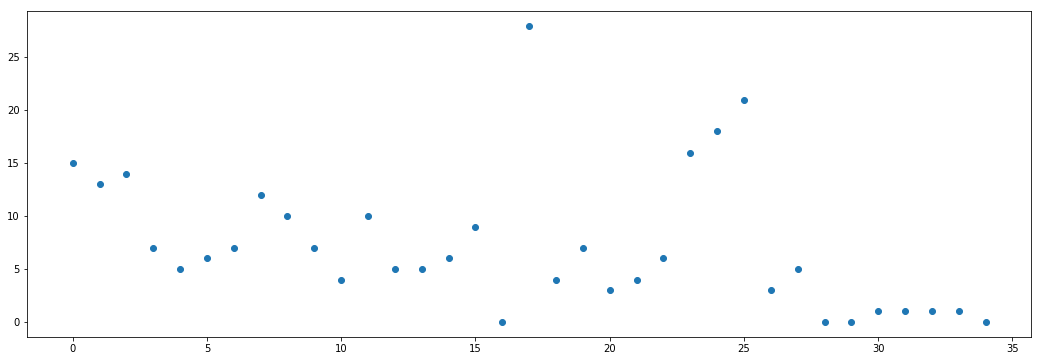

In [56]:
#item_cnt_M_sum seasonality
plt.figure(figsize=(18,6))
plt.scatter(data_all_m.loc[(data_all_m.shop_id==59)&(data_all_m.item_id==2808), 'date_block_num'], data_all_m.loc[(data_all_m.shop_id==59)&(data_all_m.item_id==2808), 'item_cnt_M_sum'])

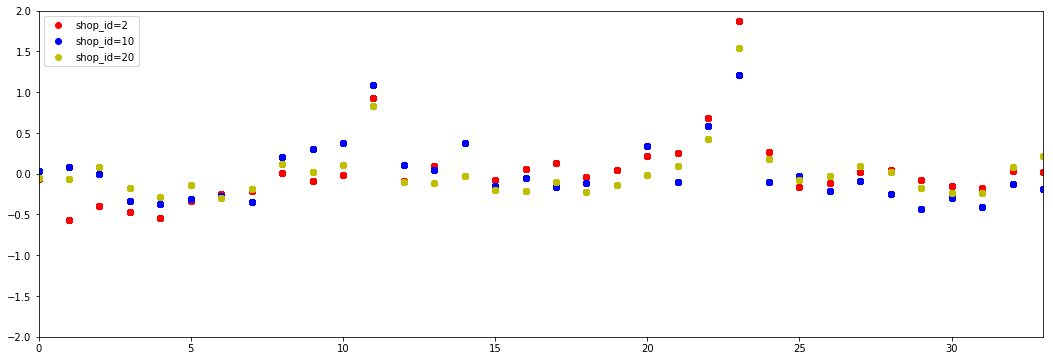

In [184]:
#Revenue by shop
plt.figure(figsize=(18,6))
plt.scatter(data_all_m.loc[data_all_m.shop_id==2, 'date_block_num'], data_all_m.loc[data_all_m.shop_id==2, 'shop_revenue_M_delta'], color='r', label='shop_id=2')
plt.scatter(data_all_m.loc[data_all_m.shop_id==10, 'date_block_num'], data_all_m.loc[data_all_m.shop_id==10, 'shop_revenue_M_delta'], color='b', label='shop_id=10')
plt.scatter(data_all_m.loc[data_all_m.shop_id==25, 'date_block_num'], data_all_m.loc[data_all_m.shop_id==25, 'shop_revenue_M_delta'], color='y', label='shop_id=25')
plt.legend(loc='upper left')
plt.xlim(0,33)
plt.ylim(-2,2)
plt.show()

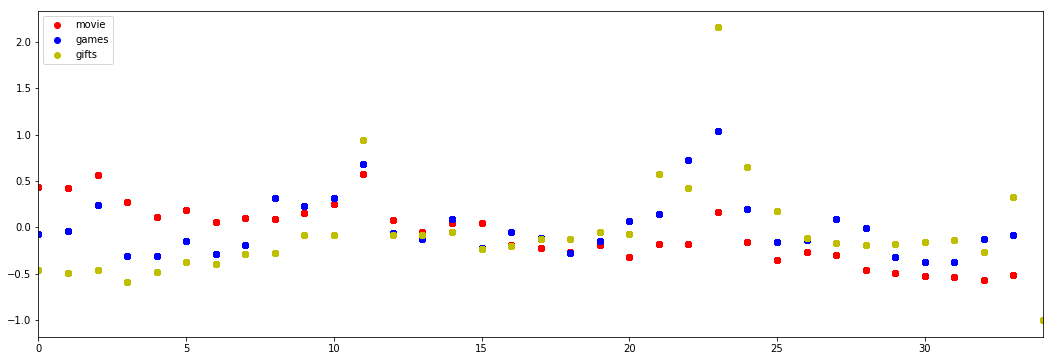

In [36]:
#Revenue by categories
plt.figure(figsize=(18,6))
plt.scatter(data_all_m.loc[data_all_m.category_movie==1, 'date_block_num'], data_all_m.loc[data_all_m.category_movie==1, 'category_revenue_M_delta'], color='r', label='movie')
plt.scatter(data_all_m.loc[data_all_m.category_games==1, 'date_block_num'], data_all_m.loc[data_all_m.category_games==1, 'category_revenue_M_delta'], color='b', label='games')
plt.scatter(data_all_m.loc[data_all_m.category_gifts==1, 'date_block_num'], data_all_m.loc[data_all_m.category_gifts==1, 'category_revenue_M_delta'], color='y', label='gifts')
plt.legend(loc='upper left')
plt.xlim(0,34)
# plt.ylim(-2,2)
plt.show()

In [ ]:
#Both revenue and counts show significant seasonality, to extract their lag features.